# 1. Data Load

In [1]:
import numpy as np
import pandas as pd

from scipy import stats #Analysis 
from scipy.stats import norm # Analysis
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
#%matplotlib tk

#import matplotlib 
#matplotlib.font_manager._rebuild()

In [2]:
# 한글 폰트가 깨지면 실행하세요! 
import matplotlib.font_manager as fm
fontlist = fm.findSystemFonts(fontpaths = None, fontext='ttf')

from matplotlib import font_manager, rc

font_path="C:/Windows/Fonts/H2HDRM.TTF"
font=font_manager.FontProperties(fname=font_path).get_name()
rc('font',family=font)

# 아래 주석을 지워서 폰트 리스트를 확인하고 한글 폰트를 font_path에 추가합니다
#fontlist[:]
#font_path = 'C:\\WINDOWS\\Fonts\\NanumGothicLight.ttf'
#font = font_manager.FontProperties(fname=font_path).get_name()
#rc('font', family=font)

In [4]:
data = pd.read_csv("C:/Users/sohee/Desktop/KW/산학연계(졸작)/산학졸작_openUP_Data/kwproja_data_big.csv",encoding='utf-8')

# EDA 

2,927,739 rows X 9 columns

- 매장 속성 정보
  - shop_code -> 식별자 feature, input feature로는 사용하지 않지만 분류를 위해서는 사용할 수 있을 것 같음  
  - shop_name -> input feature로는 사용하지 않음 (NLP deep learning 가능성 있음)
  - longtitude : 경도, latitude : 위도 -> 매장 위치 (회사 근처, 학교 근처 등 매출 영향성 있음) -> 군집화, labeling 필요
  - shop_type_big -> 15 category  -> 업종 (매출 영향성 있음)
  - shop_type_small -> 61 category

- 매출 정보
  - date -> 24 category, 201606~ 201805 까지의 data
  - monthly_gain / avearge_sale_price = 한달 총 판매수

- 매출 통계 정보-> X


##### monthly_gain과 average_sale_price 중 어느 것을 y값으로 둘 것인가? 
- 월매출 예측 문제로 가정하고 montly_gain 을 y값으로 예측하는 모델 만들기

##### shop_code는 input feature에 넣어야 하는가?
- 특별한 브랜드가 y값을 결정하는 과적합 요소가 될 수 있으므로
- X 에서 shop code, shop name 제외하는 것도 방법
- 어느 위치에 어떤 업종으로 어떤 객단가인 매장을 오픈하면 월매출이 어떻게 될까? 문제
 - X: shop type big, shop type small, longitude, latitude, avg_sale_price, 
 - y: montly_gain

In [ ]:
data.columns

In [ ]:
data.info()

# 3. Preprocessing
- missing value 제거 
    - monthly_gain : 3,605 제거 -> 149,790
    - shop_type_big : 4,303 제거 -> 145,487 
    - gender feature : 1,187 제거 -> 144,300
- shop_code, shop_name : 식별자 feature 이므로 drop 
- date : 아직은 쓸 수 없으므로 drop
    - 여기까지 총 144,300 X 27
- shop_type_big(13), shop_type_small(367) : label encodding
- longitude, latitude : clustering을 통해 labeling 후 해당 두 열은 drop 
- MinMaxSaclar 정규화 -> 정규화 column의 범위는??

In [5]:
# 원본 data와 따로 관리 -> original data = data, input data = input_data 
# feature drop
input_data = data.copy()
input_data = input_data.drop(['date', 'shop_code', 'shop_name'], axis=1)

In [6]:
# There are no missing values 
# missing value drop - monthly_gain
null_index = input_data[input_data['monthly_gain']==0].index 
print(len(null_index)) 
input_data = input_data.drop(null_index)

# missing value drop - shop_type_big
null_index = input_data[input_data['shop_type_big'].isnull()==True].index
input_data = input_data.drop(null_index)

# There is no "null" in "shop_type_small" feature 
print(len(input_data['shop_type_small'].unique()))
print(input_data['shop_type_small'].isnull().value_counts())

0
61
False    2927739
Name: shop_type_small, dtype: int64


In [7]:
# LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
input_data['shop_type_big'] = le.fit_transform(list(input_data['shop_type_big']))   # fit transform으로 한번에 처리 가능
#le.classes_

le = LabelEncoder()
input_data['shop_type_small'] = le.fit_transform(list(input_data['shop_type_small'])) 
#le.classes_

In [ ]:
# Labeling - KMeans Clustering 
# longitude + latitude = geo 
# So we get inpute_data = 144,300 X 27
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=9).fit(input_data[['latitude', 'longitude']])
print(kmeans.cluster_centers_)
print(kmeans.labels_)

# longitude + latitude = geo 
# So we get inpute_data = 2,927,739 rows × 5 columns
input_data['geo'] = kmeans.labels_

sns.scatterplot(x='longitude' , y='latitude', hue="geo", data=input_data, palette="Paired")
plt.title('k-mean')

input_data = input_data.drop(['longitude', 'latitude'], axis=1)

In [9]:
# average_sale_price -> skewed 된 feature 
# log정규화 
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer

scale_cols = ['average_sale_price']

for _ in scale_cols : 
    scaled_data = pd.DataFrame(np.log1p(input_data[_]))
    input_data[_] = scaled_data

<AxesSubplot:xlabel='shop_type_big', ylabel='average_sale_price'>

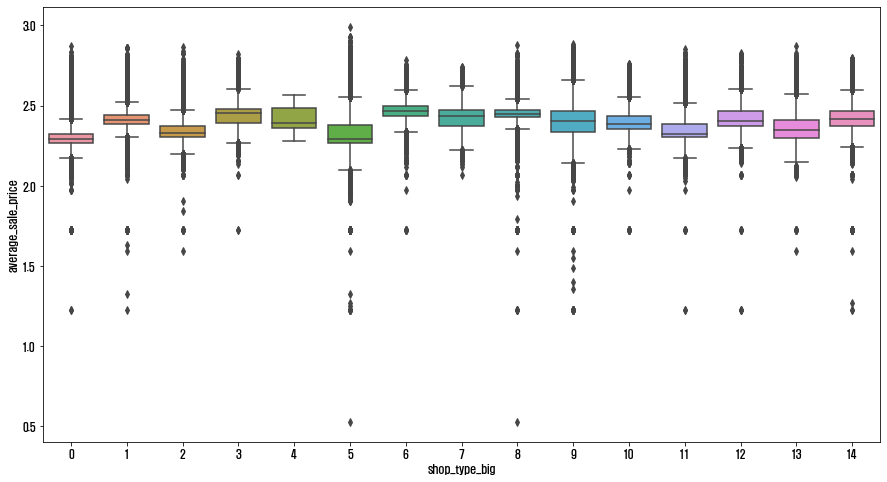

In [10]:
rcParams['figure.figsize'] = 15,8
sns.boxplot(x='shop_type_big', y='average_sale_price', data=input_data)

In [ ]:
ax = plt.subplots()
ax = sns.distplot(input_data['monthly_gain'], hist=False)
ax.set_title('Total Gain Density')
ax.set_xlabel('Monthly Gain')
ax.set_ylabel('Unit Probability')
print(input_data['monthly_gain'].value_counts())

# 4. 타겟변수 확인
why(or when) to use log transform in ML? 
- target variable이 non-negative values 일때만 
- outlier 값들도 사용해야 하는 경우, outliers that can't be filtered out as they are important to the model.
- 현재 주어진 data도 좌측으로 치우쳐진 (right skewed) 형태, 굉장히 극소수의 업종들만이 굉장히 큰 매출을 만들어낼 수 있는 것으로 보임 
- 어떤 column, feature가 가장 monthly_gain과 상관관계가 높을까요? 
- kaggle house price prediction 대회에서도 RMSE가 아닌 RMSLE를 사용함 -> log를 씌운 형태인데 target variable인 집값의 범위가 넒기 때문

- Skewness: The longer the right tail, the more positive the tail
- Kurtosis (kurtosis / kurtosis): If the kurtosis value (K) is close to 3, the scatter is close to the normal distribution. (K <3), the distributions can be judged to be flattened more smoothly than the normal distribution, and if the kurtosis is a positive number larger than 3 (K> 3), the distribution can be considered to be a more pointed distribution than the normal distribution

In [ ]:
print("Skewness: %f" % input_data['monthly_gain'].skew())
print("Kurtosis: %f" % input_data['monthly_gain'].kurt())

In [ ]:
plots=pd.DataFrame()
plots['original']=input_data['monthly_gain']
plots['transformed']=np.log1p(input_data['monthly_gain'])
plots['backToOriginal']=np.expm1(np.log1p(input_data['monthly_gain']))

fig, ax = plt.subplots(1,3,figsize=(15,5))
sns.distplot(plots['original'], ax=ax[0]);
sns.distplot(plots['transformed'], ax=ax[1]);
sns.distplot(plots['backToOriginal'], ax=ax[2]);

In [ ]:
fig = plt.figure(figsize = (15,10))

fig.add_subplot(1,2,1)
res = stats.probplot(input_data['monthly_gain'], plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(input_data['monthly_gain']), plot=plt)

# 5. Modeling
- XGB
    - 타겟변수 정규화 실행 
- LGBM
    - loss parameter : tweedie 
- K-Fold Cross Validation (k=5)

In [ ]:
# pandas option 설정 하는 코드
# monthly_gain의 경우 부동소수점으로 나타나서 보기 어려울땐 윗 줄의 주석을 제거하고 아래에 주석을 추가하고
# 다시 원래대로 돌리고 싶다면 아래에 주석제거, 위에 주석추가
pd.options.display.float_format = '{:.2f}'.format
#pd.reset_option('display.float_format')

input_data.head()

In [ ]:
input_data_y = input_data['monthly_gain'].copy()
input_data_X = input_data.drop(['monthly_gain'], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split, cross_validate, KFold, TimeSeriesSplit,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, r2_score

from lightgbm import LGBMRegressor
from lightgbm import plot_importance 
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.linear_model import Lasso

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2,      
    shuffle=True)  

##### Lasso 모델 파라미터 튜닝시도

In [ ]:
lasso=Lasso()
lasso.fit(train_X,train_y)
print(lasso.score(train_X,train_y))
print(lasso.score(test_X,test_y))

In [ ]:
train_score=[]
test_score=[]
alpha_list=[0.001,0.01,0.1,1,10,100]
for alpha in alpha_list:
    lasso=Lasso(alpha=alpha,max_iter=10000)
    lasso.fit(train_X,train_y)
    train_score.append(lasso.score(train_X,train_y))
    test_score.append(lasso.score(test_X,test_y))
plt.plot(np.log10(alpha_list),train_score)
plt.plot(np.log10(alpha_list),test_score)
plt.show()

In [ ]:
lasso=Lasso()
lasso.fit(train_X,train_y)

print("훈련 세트의 정확도 : {:.2f}".format(lasso.score(train_X, train_y)))

print("테스트 세트의 정확도 : {:.2f}".format(lasso.score(test_X, test_y)))

print("사용한 특성의 수 : {}".format(np.sum(lasso.coef_ != 0)))

print("사용한 max_iter : {}".format(lasso.n_iter_))

In [ ]:
#test1
lasso1= Lasso(alpha=0.01, max_iter=100000).fit(train_X, train_y)

print("훈련 세트의 정확도 : {:.2f}".format(lasso1.score(train_X, train_y)))

print("테스트 세트의 정확도 : {:.2f}".format(lasso1.score(test_X, test_y)))

print("사용한 특성의 수 : {}".format(np.sum(lasso1.coef_ != 0)))

print("사용한 max_iter : {}".format(lasso1.n_iter_))

In [ ]:
#test2
lasso2= Lasso(alpha=0.0001, max_iter=100000).fit(train_X, train_y)

print("훈련 세트의 정확도 : {:.2f}".format(lasso2.score(train_X, train_y)))

print("테스트 세트의 정확도 : {:.2f}".format(lasso2.score(test_X, test_y)))

print("사용한 특성의 수 : {}".format(np.sum(lasso2.coef_ != 0)))

print("사용한 max_iter : {}".format(lasso2.n_iter_))

##### Lasso parameter 튜닝 시도실패 -> default값으로 모델구현

In [ ]:
model_lasso=Lasso()

In [ ]:
# Lasso k-fold
kfold = KFold(n_splits=5, shuffle=True, random_state = 7)
cv_accuracy = []
n_iter =0

for train_index, valid_index in kfold.split(train_X):  # 데이터를 kfold = 5 로 분할
    x_train, x_valid = train_X.iloc[list(train_index)], train_X.iloc[list(valid_index)]
    y_train, y_valid = train_y.iloc[list(train_index)], train_y.iloc[list(valid_index)]
    #y_train, y_valid = np.log1p(y_train), np.log1p(y_valid)

    model_lasso.fit(x_train, y_train)
    pred = model_lasso.predict(x_valid)
    n_iter += 1
    
    mse = np.round(mean_squared_error(y_valid, pred), 4) # 소수점 4자리 반올림
    rmse = np.sqrt(mse)
    train_size = x_train.shape[0]
    test_size = x_valid.shape[0]
    
    print('\n#{0} 교차 검증 rmse : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, rmse, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,valid_index))
    cv_accuracy.append(rmse)
    
print('\n## 평균 검증 rmse:', np.mean(cv_accuracy))

##### XGB, LGBM 모델 (기존코드와 동일)

In [ ]:
model_xgb = XGBRegressor()
model_lgbm = LGBMRegressor()

In [ ]:
# XGB k-fold
kfold = KFold(n_splits=5, shuffle=True, random_state = 7)
cv_accuracy = []
n_iter =0

for train_index, valid_index in kfold.split(train_X):  # 데이터를 kfold = 5 로 분할
    x_train, x_valid = train_X.iloc[list(train_index)], train_X.iloc[list(valid_index)]
    y_train, y_valid = train_y.iloc[list(train_index)], train_y.iloc[list(valid_index)]
    #y_train, y_valid = np.log1p(y_train), np.log1p(y_valid)

    model_xgb.fit(x_train, y_train)
    pred = model_xgb.predict(x_valid)
    n_iter += 1
    
    mse = np.round(mean_squared_error(y_valid, pred), 4) # 소수점 4자리 반올림
    rmse = np.sqrt(mse)
    train_size = x_train.shape[0]
    test_size = x_valid.shape[0]
    
    print('\n#{0} 교차 검증 rmse : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, rmse, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,valid_index))
    cv_accuracy.append(rmse)
    
print('\n## 평균 검증 rmse:', np.mean(cv_accuracy))

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state = 7)
cv_accuracy = []
n_iter =0

for train_index, valid_index in kfold.split(train_X):  # 데이터를 kfold = 5 로 분할
    x_train, x_valid = train_X.iloc[list(train_index)], train_X.iloc[list(valid_index)]
    y_train, y_valid = train_y.iloc[list(train_index)], train_y.iloc[list(valid_index)]
    #y_train, y_valid = np.log1p(y_train), np.log1p(y_valid)
    
    model_lgbm.fit(x_train, y_train)
    pred = model_lgbm.predict(x_valid)
    n_iter += 1
    
    mse = np.round(mean_squared_error(y_valid, pred), 4) # 소수점 4자리 반올림
    rmse = np.sqrt(mse)
    train_size = x_train.shape[0]
    test_size = x_valid.shape[0]
    
    print('\n#{0} 교차 검증 rmse : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, rmse, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,valid_index))
    cv_accuracy.append(rmse)
    
print('\n## 평균 검증 rmse:', np.mean(cv_accuracy))

##### 각 모델 pred

In [ ]:
#pred_xgb = model_xgb.predict(test_X)
#pred_lgbm = model_lgbm.predict(test_X)
pred_lasso=model_lasso.predict(test_X)

In [ ]:
#pred_xgb = np.exp(pred_xgb)-1
#pred_lgbm = np.exp(pred_lgbm)-1

#test_y = np.exp(test_y)-1

## Prediction

In [ ]:
def plot_history(history):
    #hist = pd.DataFrame(history.history)
    #history['epoch'] = history.epoch
    
    plt.figure(figsize=(8,12))
    
    # Mean Abs Error : 평균 절대 오차, 측정값에서 오차의 크기로 측정값과 실제값과의 차이, 절대 오차의 평균  
    # -> 측정하고자 하는 값을 정확하게 측정하지 못함으로써 발생
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.legend()
    
    # Mean Square Error : 평균 제곱 오차, 오차의 제복에 대한 평균을 취한 값
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.legend()
    plt.show()
    
def show_pred(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    
    df_result = pd.DataFrame(list(zip(true_y, pred)), columns=['true_y', 'prediction'])
    return df_result

def show_mse_rmse(test_y, pred) :
    mse = mean_squared_error(test_y, pred)
    print("mse : %f" % mse)
    
    rmse = np.sqrt(mse)
    print("rmse: %f \n" %rmse)
    
    
def show_mae(test_y,pred):    
    mae = mean_absolute_error(test_y, pred)
    print("mae : %f" %mae)
    

def show_r2_score(test_y, pred, test_X) : 
    r2 = r2_score(pred, test_y)
    print("r2 : %f " % r2)
    
    # 독립변수가 많을 수록 결정계수 r2 값은 커지므로, 독립변수가 2개 이상일 경우 조정된 결정계수 adj_r2를 사용
    # 기존의 결정계수 r2에 n(데이터 개수) 와 k(변수 개수)가 추가 됨 
    # r2 score는 regression model의 훌륭한 평가 지표이지만, 예측 모델과 실제 모델의 분산이 얼마나 비슷한지에 기반하기에 
    # 예측값과 실제값이 많이 달라도 분산만 비슷하면 높은 점수를 얻을 수 있다는 맹점이 있다 
    adj_r2 = 1 - (1-r2)*(test_X.shape[0]-1)/(test_X.shape[0]-test_X.shape[1]-1)
    print("adj_r2_score : %f \n" % adj_r2)
    
def show_prediction_error(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    error = pred - true_y
    plt.hist(error, bins=25)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    
def feature_importance(model_xgb) : 
    %matplotlib inline
    plt.rcParams['axes.unicode_minus'] = False
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)
    
def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

In [ ]:
show_pred(test_y, pred_xgb)

In [ ]:
show_pred(test_y, pred_lgbm)

In [ ]:
show_pred(test_y, pred_lasso)

In [ ]:
show_mse_rmse(test_y, pred_xgb)
show_r2_score(test_y, pred_xgb, test_X)
show_mae(test_y,pred_xgb)

In [ ]:
show_mse_rmse(test_y, pred_lgbm)
show_r2_score(test_y, pred_lgbm, test_X)
show_mae(test_y,pred_lgbm)

In [ ]:
show_mse_rmse(test_y, pred_lasso)
show_r2_score(test_y, pred_lasso, test_X)
show_mae(test_y,pred_lasso)